# Imports

In [ ]:
!pip -q install torch

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import AutoModel, AutoTokenizer
import torch

# Download Data

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1tDw00yLk42PhSndvrpzJrLnu6ydQIY2b' -O raw_single_cell_tcr_data_acs_controllers_and_progressors.csv
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1uZuac6-X6_6rTZRkmNkASJFtOvt3-Mis' -O immunoSeq_samples_key.csv
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1S7wYkHOOLJtb7O6GjhtmIk8aQmDgwi3D' -O study_sample_key.csv

--2024-05-02 23:44:48--  https://drive.google.com/uc?export=download&id=1tDw00yLk42PhSndvrpzJrLnu6ydQIY2b
Resolving drive.google.com (drive.google.com)... 74.125.68.138, 74.125.68.101, 74.125.68.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.68.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1tDw00yLk42PhSndvrpzJrLnu6ydQIY2b&export=download [following]
--2024-05-02 23:44:49--  https://drive.usercontent.google.com/download?id=1tDw00yLk42PhSndvrpzJrLnu6ydQIY2b&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.12.132, 2404:6800:4003:c11::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.12.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41943373 (40M) [application/octet-stream]
Saving to: ‘raw_single_cell_tcr_data_acs_controllers_and_progressors.csv’

raw_single_cell_tcr 10

# Load Data

In [ ]:
df_raw_controllers_and_progressors = pd.read_csv("raw_single_cell_tcr_data_acs_controllers_and_progressors.csv")
# df_immunoSeq_samples_key =  pd.read_csv("immunoSeq_samples_key.csv")
# df_study_sample_key = pd.read_csv("study_sample_key.csv")

In [ ]:
df_raw_controllers_and_progressors = df_raw_controllers_and_progressors.drop("Unnamed: 0", axis=1)

# EDA

In [ ]:
df_raw_controllers_and_progressors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37674 entries, 0 to 37673
Data columns (total 97 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   plateBC              37582 non-null  float64
 1   well                 37674 non-null  object 
 2   PID                  37674 non-null  object 
 3   project              37674 non-null  object 
 4   seqName              36737 non-null  object 
 5   seqId                36737 non-null  float64
 6   batch                37674 non-null  object 
 7   himcBC               37674 non-null  object 
 8   batch_bc_well        37674 non-null  object 
 9   sampleId             37674 non-null  object 
 10  donorId              37674 non-null  object 
 11  visit                37674 non-null  object 
 12  Days.To.TB           19330 non-null  float64
 13  plateNo              37674 non-null  int64  
 14  gatingPW             37674 non-null  object 
 15  stim                 37674 non-null 

## Selecting Relevant Features

In [ ]:
# Gene Data
tcr_genes = ["TCRa.sequence", "TCRb.sequence", "alt.TCRa.sequence"]

# TCR specific data
cdr3a_values = ["CDR3a", "Va", "Ja", "CDR3a.dominance", "CDR3a_reads"]
cdr3a_values_alt = ["alt.CDR3a", "alt.Va", "alt.Ja", "alt.CDR3a.dominance", "alt.CDR3a_reads"]
cdr3b_values = ["CDR3b", "Vb", "Db", "Jb", "CDR3b.dominance", "CDR3b_reads"]

# Participant data
patient = ["PID", "donorId", "sex", "age_at_enrolment", "visit"]
label = ["donorGrp"]

# Immune function and gene variation data
cell_markers = ["CD8", "CD4", "CD3", "CD69", "CD137", "CD3", "CD26", "CD154"]

In [ ]:
tcr_specific_values = cdr3a_values + cdr3a_values_alt + cdr3b_values

base_line_tcr_value = [
    value for value in tcr_specific_values
    if value not in ["Va", "Ja", "alt.Va", "alt.Ja", "Vb", "Db", "Jb"]
]

baseline_features = patient + base_line_tcr_value + label

In [ ]:
df_baseline_data = df_raw_controllers_and_progressors[baseline_features]

In [ ]:
df_baseline_data.describe()

,age_at_enrolment,CDR3a.dominance,CDR3a_reads,alt.CDR3a.dominance,alt.CDR3a_reads,CDR3b.dominance,CDR3b_reads
count,37674.000000,26376.000000,37674.000000,10693.000000,37674.000000,21404.000000,37674.000000
mean,15.460264,0.749478,1643.350666,0.288993,255.603387,0.889350,1268.164331
std,1.469363,0.167277,2589.463661,0.104619,650.267341,0.030619,1639.600098
min,12.000000,0.300000,0.000000,0.100000,0.000000,0.800000,0.000000
25%,14.000000,0.607750,0.000000,0.200000,0.000000,0.873000,0.000000
50%,16.000000,0.805000,959.000000,0.293000,0.000000,0.896000,476.000000
75%,17.000000,0.896000,2297.000000,0.380000,204.000000,0.912000,2209.000000
max,18.000000,1.000000,55352.000000,0.485000,19327.000000,0.973000,23103.000000


## Obersevations per participant

In [ ]:
df_raw_controllers_and_progressors.groupby("donorId").agg(
    num_observations=("donorId", "count"),
    group = ("donorGrp", "first"),
).groupby("group").describe().T\
  .reset_index(level=0, drop=True)\
  .rename_axis(index=None, columns=None)\
  .rename(columns={"Non Progressor": "Controller (Group 0)", "Progressor": "Progressor (Group 1)"})

,Controller (Group 0),Progressor (Group 1)
count,35.000000,35.000000
mean,524.114286,552.285714
std,349.561976,369.099426
min,94.000000,59.000000
25%,275.500000,281.500000
50%,423.000000,469.000000
75%,655.500000,799.000000
max,1410.000000,1503.000000


# Data Pre-Processing

## Deduplication

In [ ]:
dff_data = df_baseline_data.drop_duplicates().reset_index(drop=True)
len(dff_data)

28551

## Convert dtypes

In [ ]:
dff_data.head()

,PID,donorId,sex,age_at_enrolment,visit,CDR3a,CDR3a.dominance,CDR3a_reads,alt.CDR3a,alt.CDR3a.dominance,alt.CDR3a_reads,CDR3b,CDR3b.dominance,CDR3b_reads,donorGrp
0,04-0333-D180,04-0333,female,17,D180,CILRDVWGNNARLMF,0.869,1415,NaN,NaN,0,CASSEQVGLFF,0.940,2071,Non Progressor
1,04-0333-D180,04-0333,female,17,D180,CAVYNYGQNFVF,0.502,873,NaN,0.464,807,CSGGRGGNYEQYF,0.881,1313,Non Progressor
2,04-0333-D180,04-0333,female,17,D180,CIVSPINNAGNMLTF,0.634,1196,CLLGLRTNFGNEKLTF,0.277,523,CASRSVQPNTEAFF,0.904,2052,Non Progressor
3,04-0333-D180,04-0333,female,17,D180,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,Non Progressor
4,04-0333-D180,04-0333,female,17,D180,CAVTRGTGGFKTIF,0.911,649,NaN,NaN,0,CSVDPGGGAFF,0.917,1366,Non Progressor


In [ ]:
# Convert sequences to strings
sequence_columns = ["CDR3a", "CDR3b", "alt.CDR3a"]
dff_data[sequence_columns] = dff_data[sequence_columns].astype(str)

In [ ]:
# Convert vistis to temporal
dff_data['visit_days'] = dff_data['visit'].apply(lambda x: int(x.strip('D')))

In [ ]:
# Convert 'sex' column to binary
dff_data['sex_binary'] = dff_data['sex'].map({'male': 1, 'female': 0})

In [ ]:
# Convert 'donorGrp' column to binary
dff_data['group'] = dff_data['donorGrp'].map({'Non Progressor': 0, 'Progressor': 1})

In [ ]:
dff_data_processed = dff_data[
    ["donorId", ] + ["visit_days", "sex_binary", "group"] + sequence_columns + \
    ["alt.CDR3a.dominance", "CDR3a.dominance", "CDR3a_reads", "CDR3b_reads"]

]

### Unique Values per Feature

In [ ]:
dff_data.nunique()

PID                      125
donorId                   70
sex                        2
age_at_enrolment           7
visit                      5
CDR3a                  15272
CDR3a.dominance          700
CDR3a_reads             6370
alt.CDR3a               4935
alt.CDR3a.dominance      384
alt.CDR3a_reads         2453
CDR3b                  16517
CDR3b.dominance          163
CDR3b_reads             5529
donorGrp                   2
visit_days                 5
sex_binary                 2
group                      2
dtype: int64

## Create TCR-BERT Embeddings

In [ ]:
import os
import tempfile
from typing import Iterable

from transformers import BertModel, BertTokenizer

### Helpers and Globals

In [ ]:
def write_vocab(vocab: Iterable[str], fname: str) -> str:
    """
    Write the vocabulary to the fname, one entry per line
    Mostly for compatibility with transformer BertTokenizer
    """
    with open(fname, "w") as sink:
        for v in vocab:
            sink.write(v + "\n")
    return fname

In [ ]:
# https://github.com/wukevin/tcr-bert/blob/63aa483ec25a8f4727d1905267499ede75f524de/tcr/featurization.py#L171

AA_TRIPLET_TO_SINGLE = {
    "ARG": "R",
    "HIS": "H",
    "LYS": "K",
    "ASP": "D",
    "GLU": "E",
    "SER": "S",
    "THR": "T",
    "ASN": "N",
    "GLN": "Q",
    "CYS": "C",
    "SEC": "U",
    "GLY": "G",
    "PRO": "P",
    "ALA": "A",
    "VAL": "V",
    "ILE": "I",
    "LEU": "L",
    "MET": "M",
    "PHE": "F",
    "TYR": "Y",
    "TRP": "W",
}

# Pad with $ character
PAD = "$"
MASK = "."
UNK = "?"
SEP = "|"
CLS = "*"

# 21 amino acids
AMINO_ACIDS = "RHKDESTNQCUGPAVILMFYW"
assert len(AMINO_ACIDS) == 21
assert all([x == y for x, y in zip(AMINO_ACIDS, AA_TRIPLET_TO_SINGLE.values())])
AMINO_ACIDS_TO_IDX = {aa: i for i, aa in enumerate(AMINO_ACIDS)}


#
AMINO_ACIDS_WITH_ALL_ADDITIONAL = AMINO_ACIDS + PAD + MASK + UNK + SEP + CLS

AMINO_ACIDS_WITH_ALL_ADDITIONAL_TO_IDX = {
    aa: i for i, aa in enumerate(AMINO_ACIDS_WITH_ALL_ADDITIONAL)
}


In [ ]:
def get_aa_bert_tokenizer(
    max_len: int = 64, d=AMINO_ACIDS_WITH_ALL_ADDITIONAL_TO_IDX
) -> BertTokenizer:
    """
    Tokenizer for amino acid sequences. Not *exactly* the same as BertTokenizer
    but mimics its behavior, encoding start with CLS and ending with SEP

    >>> get_aa_bert_tokenizer(10).encode(insert_whitespace("RKDES"))
    [25, 0, 2, 3, 4, 5, 24]
    """
    with tempfile.TemporaryDirectory() as tempdir:
        vocab_fname = write_vocab(d, os.path.join(tempdir, "vocab.txt"))
        tok = BertTokenizer(
            vocab_fname,
            do_lower_case=False,
            do_basic_tokenize=True,
            tokenize_chinese_chars=False,
            pad_token=PAD,
            mask_token=MASK,
            unk_token=UNK,
            sep_token=SEP,
            cls_token=CLS,
            model_max_len=max_len,
            padding_side="right",
        )
    return tok

In [ ]:
def insert_whitespace(seq: str) -> str:
    """
    Return the sequence of characters with whitespace after each char
    >>> insert_whitespace("RKDES")
    'R K D E S'
    """
    return " ".join(list(seq))

### Load Model

In [ ]:
def extract_valid_sequences(sequences):
  valid_sequences = []
  original_indices = []

  for idx, seq in enumerate(sequences):
    if seq == 'nan':
      continue  # Skip adding this sequence to valid_sequences
    valid_sequences.append(seq)
    original_indices.append(idx)

  return (valid_sequences, original_indices, len(sequences))

In [ ]:
# Import model from Hugging Face
tcrbert_model = BertModel.from_pretrained("wukevin/tcr-bert")

# Tokenizer; 30 is the max seq length in any of CDR3a, CDR3b, and alt.CDR3a
tcrbert_tokenizer = get_aa_bert_tokenizer(30)

In [ ]:
def get_num_params(model):
  """
  Returns the total number of parameters in a BERT variant model.
  """
  num_params = sum(p.numel() for p in model.parameters())
  return num_params

num_params = get_num_params(tcrbert_model)
print(f"Number of parameters in the TCR-BERT model: {num_params}")

Number of parameters in the TCR-BERT model: 57387264


In [ ]:
# Sequences
CDR3a_seqs, CDR3a_indices, CDR3a_len = extract_valid_sequences(dff_data_processed["CDR3a"].tolist())
CDR3b_seqs, CDR3b_indices, CDR3b_len = extract_valid_sequences(dff_data_processed["CDR3b"].tolist())
alt_CDR3b_seqs, alt_CDR3a_indices, alt_CDR3a_len = extract_valid_sequences(dff_data_processed["alt.CDR3a"].tolist())

### Create Dataloaders

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class TCRDataset(Dataset):
    def __init__(self, sequences, tokenizer=tcrbert_tokenizer, max_length=32):
        self.sequences = sequences
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        tokenized_input = self.tokenizer(
            insert_whitespace(sequence),
            return_tensors="pt",
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            add_special_tokens=True
        )
        return tokenized_input['input_ids'].squeeze(0)  # Squeeze to remove batch dimension


In [ ]:
CDR3a_dataset = TCRDataset(CDR3a_seqs)
CDR3b_dataset = TCRDataset(CDR3b_seqs)
alt_CDR3a_dataset = TCRDataset(alt_CDR3b_seqs)

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 256
CDR3a_loader = DataLoader(CDR3a_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
CDR3b_loader = DataLoader(CDR3b_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
alt_CDR3a_loader = DataLoader(alt_CDR3a_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

### Create Embeddings

In [ ]:
def generate_embeddings(data_loader, original_indices, model, device, total_seq_len):
    embedding_dim = model.config.hidden_size
    embeddings = [torch.zeros((embedding_dim,), device=device) for _ in range(total_seq_len)]
    model.to(device).eval()

    with torch.no_grad():
        for batch_idx, input_ids in enumerate(tqdm(data_loader, desc="Generating Embeddings")):
            input_ids = input_ids.to(device)
            outputs = model(input_ids)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]

            batch_start_index = batch_idx * data_loader.batch_size
            for i, embedding in enumerate(cls_embeddings):
                if batch_start_index + i < len(original_indices):
                    original_idx = original_indices[batch_start_index + i]
                    embeddings[original_idx] = embedding

    embeddings_tensor = torch.stack(embeddings)
    return embeddings_tensor

In [ ]:
# Generate embeddings for each type of dataset
CDR3a_embeddings = generate_embeddings(
    CDR3a_loader, CDR3a_indices, tcrbert_model, device, CDR3a_len
)

Generating Embeddings:   0%|          | 0/88 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Generating Embeddings: 100%|██████████| 88/88 [00:14<00:00,  5.90it/s]


In [ ]:
CDR3b_embeddings = generate_embeddings(
    CDR3b_loader, CDR3b_indices, tcrbert_model, device, CDR3b_len
)

Generating Embeddings: 100%|██████████| 84/84 [00:14<00:00,  5.74it/s]


In [ ]:
alt_CDR3a_embeddings = generate_embeddings(
    alt_CDR3a_loader, alt_CDR3a_indices, tcrbert_model, device, alt_CDR3a_len
)

Generating Embeddings: 100%|██████████| 25/25 [00:04<00:00,  5.58it/s]


In [ ]:
print(CDR3a_embeddings.shape)
print(CDR3b_embeddings.shape)
print(alt_CDR3a_embeddings.shape)

torch.Size([28551, 768])
torch.Size([28551, 768])
torch.Size([28551, 768])


### Adding embeddings to dataframe

In [ ]:
dff_data_processed['CDR3a_embedding'] = CDR3a_embeddings.cpu().numpy().tolist()
dff_data_processed['CDR3b_embedding'] = CDR3b_embeddings.cpu().numpy().tolist()
dff_data_processed['alt.CDR3a_embedding'] = alt_CDR3a_embeddings.cpu().numpy().tolist()


In [ ]:
dff_data_processed.head()

,donorId,visit_days,sex_binary,group,alt.CDR3a.dominance,CDR3a.dominance,CDR3a_reads,CDR3b_reads,CDR3a_embedding,CDR3b_embedding,alt.CDR3a_embedding
0,04-0333,180,0,0,NaN,0.869,1415,2071,"[1.4877188205718994, -0.14019626379013062, 1.1...","[2.1238317489624023, -0.2193526029586792, 1.62...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,04-0333,180,0,0,0.464,0.502,873,1313,"[1.3355662822723389, 0.5680606365203857, 0.060...","[1.2325398921966553, -0.7360079288482666, -0.3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,04-0333,180,0,0,0.277,0.634,1196,2052,"[1.662431001663208, 0.03997337073087692, 0.010...","[1.588470458984375, -0.050250597298145294, 0.7...","[0.13856112957000732, -0.767341673374176, 0.72..."
3,04-0333,180,0,0,NaN,NaN,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,04-0333,180,0,0,NaN,0.911,649,1366,"[1.6742973327636719, 0.15525837242603302, 0.76...","[2.513138771057129, 0.23424561321735382, 0.373...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Base Model

## Create Embedding Summary Stats for Baseline Model

In [ ]:
def calculate_embedding_statistics(df_data, col_name):
  df_data_stats = df_data.apply(lambda row: pd.Series({
      f"{col_name}_mean": np.mean(row[col_name]),
      f"{col_name}_median": np.median(row[col_name]),
      f"{col_name}_std": np.std(row[col_name]),
      f"{col_name}_min": np.min(row[col_name]),
      f"{col_name}_max": np.max(row[col_name]),
  }), axis=1)

  df_combined = pd.concat([df_data, df_data_stats], axis=1)

  return df_combined

In [ ]:
df_baseline = calculate_embedding_statistics(dff_data_processed, "CDR3a_embedding")
df_baseline = calculate_embedding_statistics(dff_data_processed, "CDR3b_embedding")
df_baseline = calculate_embedding_statistics(dff_data_processed, "alt.CDR3a_embedding")

In [ ]:
df_baseline.head()

,donorId,visit_days,sex_binary,group,alt.CDR3a.dominance,CDR3a.dominance,CDR3a_reads,CDR3b_reads,CDR3a_embedding,CDR3b_embedding,...,CDR3b_embedding_mean,CDR3b_embedding_median,CDR3b_embedding_std,CDR3b_embedding_min,CDR3b_embedding_max,alt.CDR3a_embedding_mean,alt.CDR3a_embedding_median,alt.CDR3a_embedding_std,alt.CDR3a_embedding_min,alt.CDR3a_embedding_max
0,04-0333,180,0,0,NaN,0.869,1415,2071,"[1.4877188205718994, -0.14019626379013062, 1.1...","[2.1238317489624023, -0.2193526029586792, 1.62...",...,0.000079,-0.039932,1.012348,-2.515254,2.820486,0.00000,0.000000,0.000000,0.000000,0.000000
1,04-0333,180,0,0,0.464,0.502,873,1313,"[1.3355662822723389, 0.5680606365203857, 0.060...","[1.2325398921966553, -0.7360079288482666, -0.3...",...,-0.000113,-0.022053,1.012374,-2.903137,2.625573,0.00000,0.000000,0.000000,0.000000,0.000000
2,04-0333,180,0,0,0.277,0.634,1196,2052,"[1.662431001663208, 0.03997337073087692, 0.010...","[1.588470458984375, -0.050250597298145294, 0.7...",...,-0.000103,-0.046434,1.012176,-2.866515,2.758358,0.00002,0.057205,1.011577,-3.011481,2.957973
3,04-0333,180,0,0,NaN,NaN,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,04-0333,180,0,0,NaN,0.911,649,1366,"[1.6742973327636719, 0.15525837242603302, 0.76...","[2.513138771057129, 0.23424561321735382, 0.373...",...,0.000008,0.000003,1.012388,-2.810546,2.803495,0.00000,0.000000,0.000000,0.000000,0.000000


## Fill na values

In [ ]:
dff_data_processed["alt.CDR3a.dominance"].fillna(0, inplace=True)
dff_data_processed["CDR3a.dominance"].fillna(0, inplace=True)

## Create train/test split

In [ ]:
# Sample test donor ids
test_donor_ids = dff_data_processed["donorId"][:20]

In [ ]:
df_train_base = dff_data_processed.loc[~dff_data_processed["donorId"].isin(test_donor_ids)]
df_test_base = dff_data_processed.loc[dff_data_processed["donorId"].isin(test_donor_ids)]

## Select Xs and y

In [ ]:
columns_to_drop = [
    "donorId",
    "group",
    "CDR3a_embedding",
    "CDR3b_embedding",
    "alt.CDR3a_embedding",
] + sequence_columns

X_train = df_train_base.drop(columns_to_drop, axis=1)
X_test = df_test_base.drop(columns_to_drop, axis=1)

y_train = df_train_base["group"]
y_test = df_test_base["group"]

## Random Forest

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Create and train the model
model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5173501577287066


## ROC Curve

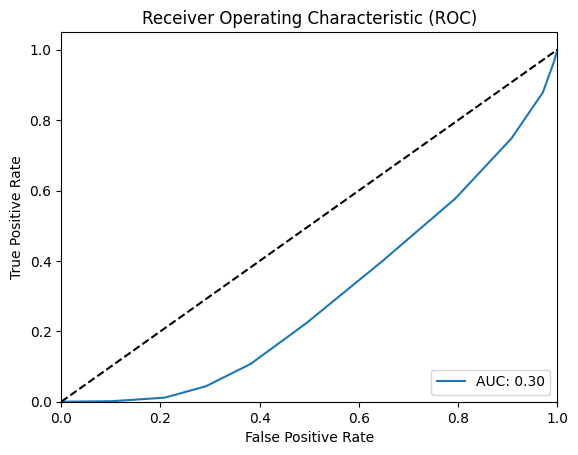

In [ ]:
# Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label="AUC: {:.2f}".format(auc))
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

## Aggregate Prediction

In [ ]:
# Load predictions into df
df_y_preds = pd.DataFrame(y_pred, columns=["prediction"])

In [ ]:
# Get rows from original df that were in the test set
dff_data_processed_sampled = dff_data_processed.loc[X_test.index].reset_index(drop=True)

In [ ]:
# Combine the two dfs
df_concat = pd.concat([dff_data_processed_sampled[["donorId"]], df_y_preds], axis=1)

In [ ]:
# Aggregate predictions for each patient by taking majority vote across
# all predictions for individual sequences for that patient
df_aggregated_predictions = df_concat.groupby('donorId')['prediction'].agg(
    lambda x: x.value_counts().index[0]
)

In [ ]:
df_merged = pd.merge(
    df_aggregated_predictions,
    dff_data_processed_sampled[["donorId", "group"]],
    on='donorId'
)

df_merged['correct'] = df_merged['prediction'] == df_merged['group']

In [ ]:
df_merged.head()

,donorId,prediction,group,correct
0,04-0333,1,0,False
1,04-0333,1,0,False
2,04-0333,1,0,False
3,04-0333,1,0,False
4,04-0333,1,0,False


In [ ]:
accuracy = df_merged['correct'].mean()
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.42
